# Float Adder RTL Design


In [2]:
from typing import Type
from collections import OrderedDict
import numpy as np
import pandas as pd
import pyrtl
from pyrtl import WireVector, Input, Output, probe, Simulation
from hardware_accelerators.dtypes import *
from hardware_accelerators.rtllib.utils.adder_utils import *
from hardware_accelerators.rtllib.utils.common import extract_float_components
from hardware_accelerators.simulation.utils import render_waveform
from hardware_accelerators.simulation.repr_funcs import *

## PyRTL Analysis


### New Wrapper Class


In [3]:
class FloatAdder:
    def __init__(
        self,
        dtype: Type[BaseFloat] = BF16,
    ):
        self.dtype = dtype
        self.bitwidth = dtype.bitwidth()

    def construct_adder(
        self,
        float_a: WireVector,
        float_b: WireVector,
    ):
        e_bits, m_bits = self.dtype.exponent_bits(), self.dtype.mantissa_bits()

        sign_a, sign_b, exp_a, exp_b, mantissa_a, mantissa_b = extract_float_components(
            float_a, float_b, e_bits, m_bits
        )

        sign_xor, exp_larger, signed_shift, mant_smaller, mant_larger = adder_stage_2(
            sign_a, sign_b, exp_a, exp_b, mantissa_a, mantissa_b, e_bits, m_bits
        )

        abs_shift = WireVector(e_bits)  # , "abs_shift")
        abs_shift <<= signed_shift[:e_bits]

        aligned_mant_msb, sticky_bit, guard_bit, round_bit = adder_stage_3(
            mant_smaller, abs_shift, m_bits, e_bits
        )

        mantissa_sum, is_neg, lzc = adder_stage_4(
            aligned_mant_msb, mant_larger, sign_xor, m_bits
        )

        final_sign, final_exp, norm_mantissa = adder_stage_5(
            mantissa_sum,
            sticky_bit,
            guard_bit,
            round_bit,
            lzc,
            exp_larger,
            sign_a,
            sign_b,
            signed_shift,
            is_neg,
            e_bits,
            m_bits,
        )

        probe(sign_a, "sign_a")
        probe(sign_b, "sign_b")
        probe(exp_a, "exp_a")
        probe(exp_b, "exp_b")
        probe(mantissa_a, "mantissa_a")
        probe(mantissa_b, "mantissa_b")
        probe(sign_xor, "sign_xor")
        probe(exp_larger, "exp_larger")
        probe(mant_larger, "mant_larger")
        probe(mant_smaller, "mant_smaller")
        probe(signed_shift, "signed_shift")
        probe(abs_shift, "abs_shift")
        probe(aligned_mant_msb, "aligned_mant_msb")
        probe(sticky_bit, "sticky_bit")
        probe(guard_bit, "guard_bit")
        probe(round_bit, "round_bit")
        probe(mantissa_sum, "mantissa_sum")
        probe(is_neg, "is_neg")
        probe(lzc, "lzc")
        probe(final_exp, "final_exp")
        probe(final_sign, "final_sign")

        out = WireVector(self.bitwidth)  # , "float_result")
        out <<= pyrtl.concat(final_sign, final_exp, norm_mantissa)
        return out

    @property
    def repr_map(self):
        return OrderedDict(
            [
                ("float_a", repr_bf16),
                ("float_b", repr_bf16),
                ("result", repr_bf16),
                ("sign_a", repr_sign),
                # ("sign_b", repr_sign),
                # ("sign_xor", repr_num),
                # ("exp_a", repr_exp),
                # ("exp_b", repr_exp),
                # ("exp_larger", repr_exp),
                # ("mantissa_a", repr_mantissa),
                # ("mantissa_b", repr_mantissa),
                # ("mant_larger", repr_mantissa),
                # ("mant_smaller", repr_mantissa),
                # ("mantissa_sum", repr_mantissa_sum),
                ("is_neg", repr_num),
                ("final_sign", repr_sign),
            ]
        )

    def setup_sim(self):
        pyrtl.reset_working_block()

        float_a = Input(self.dtype.bitwidth(), "float_a")
        float_b = Input(self.dtype.bitwidth(), "float_b")
        result = Output(self.dtype.bitwidth(), "result")
        result <<= self.construct_adder(float_a, float_b)

        self.sim = Simulation()

    def __call__(self, a, b, render=False):
        if not hasattr(self, "sim"):
            self.setup_sim()

        self.sim.step(
            {
                "float_a": self.dtype(a).binint,
                "float_b": self.dtype(b).binint,
            }
        )

        expected = self.dtype(a) + self.dtype(b)
        sim_result = self.dtype(binint=self.sim.inspect("result"))

        # assert sim_result == expected, f"Expected {expected}, got {sim_result}"

        if render:
            render_waveform(
                self.sim,
                trace_list=[w for w in self.repr_map],
                repr_per_name={w: fn for w, fn in self.repr_map.items()},
            )

            if sim_result == expected:
                print("Pass!")
            else:
                print("Fail!")
            print(f"Expected: {expected}, got: {sim_result}")

        return float(sim_result), float(expected)

In [ ]:
def test_adder(start: int, stop: int, n: int):
    adder = FloatAdder()
    nums = np.linspace(start, stop, n)
    results = []
    for a in nums:
        for b in nums:
            calc, expected = adder(a, b)
            results.append(
                {
                    "result": calc,
                    "expected": expected,
                    "a": a,
                    "b": b,
                    "pass": calc == expected,
                    "error": abs(calc - expected),
                    "error_pct": (
                        abs(calc - expected) / expected * 100
                        if expected != 0
                        else "N/A"
                    ),
                }
            )
    return pd.DataFrame(results)

In [ ]:
df = test_adder(-50, 50, 100)
df

,result,expected,a,b,pass,error,error_pct
0,-100.0,-100.0,-50.0,-50.000000,True,0.0,-0.0
1,-98.5,-98.5,-50.0,-48.989899,True,0.0,-0.0
2,-97.5,-97.5,-50.0,-47.979798,True,0.0,-0.0
3,-96.5,-96.5,-50.0,-46.969697,True,0.0,-0.0
4,-95.5,-95.5,-50.0,-45.959596,True,0.0,-0.0
...,...,...,...,...,...,...,...
9995,95.5,95.5,50.0,45.959596,True,0.0,0.0
9996,96.5,96.5,50.0,46.969697,True,0.0,0.0
9997,97.5,97.5,50.0,47.979798,True,0.0,0.0
9998,98.5,98.5,50.0,48.989899,True,0.0,0.0


<Axes: >

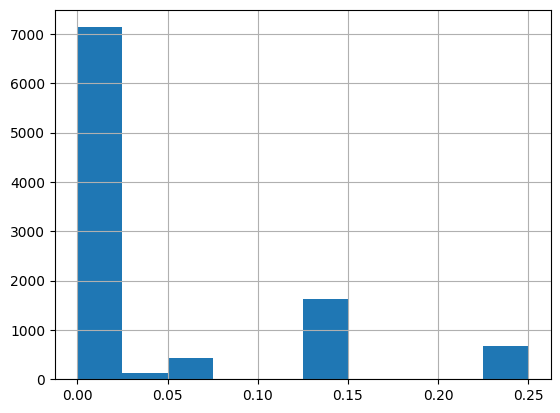

In [140]:
df["error"].hist()

## Deducting a Correct Truth Table for Sign Bit


| sign_a | is_neg    | sign_out |
| ------ | --------- | -------- |
| 0 (+)  | 0 (False) | 0 (+)    |
| 0 (+)  | 1 (True)  | 1 (-)    |
| 1 (-)  | 0 (False) | 1 (-)    |
| 1 (-)  | 1 (True)  | 0 (+)    |


In [7]:
adder = FloatAdder()

In [8]:
adder(2.5, -2)
adder(2, -3)
adder(-2, 2.5)
adder(-3, 2, True)

<IPython.core.display.Javascript object>

Pass!
Expected: -1.0, got: -1.0


(-1.0, -1.0)

In [ ]:
adder.setup_sim()
adder(2.5, -2)
adder(2, -3)
adder(-2, 2.5)
adder(-3, 2, True)

<IPython.core.display.Javascript object>

Pass!
Expected: -1.0, got: -1.0


(-1.0, -1.0)